# Beam dimensional reduction: basic example

Using the assumption of cylindrical invariance, we derive the effective elastic constitutive coefficients of a one-dimensional beam model representing a prismatic elastic body. In this elementary presentation, we limit attention to linear elasticity and neglect any gradient effect (i.e., we derive the leading-order contributions to the 1D energy). The approach works for arbitrary shapes of cross-section, arbitrary material symmetries and constitutive laws, and does not require the elastic properties to be homogeneous in the cross-section. It does not make any ad hoc kinematic assumption such as unshearability.

We provide below a basic code for the case of a beam with an elliptical  cross-section based on the FEniCSx library .

Authors :

 - Basile Audoly, basile.audoly@polytechnique.edu
 - Corrado Maurini, corrado.maurini@sorbonne-universite.fr

Copyright (c) 2024. All rights reserved.

This work is licensed under the terms of the MIT license.
For a copy, see <https://opensource.org/licenses/MIT>.

The code is based on the FEniCSx library, which is distributed under the LGPL license.
For more information, see <https://fenicsproject.org/license/>.

The fenicsx version is 0.8.0


In [1]:
from pathlib import Path
import dolfinx
import dolfinx.fem.petsc
import gmsh
import numpy as np
import pyvista
import ufl
from dolfinx import fem
from dolfinx.io import gmshio
from mpi4py import MPI
from plots import plot_displacement_stress

pyvista.OFF_SCREEN = False

# Parameters

In [2]:
geometrical_parameters = {
    "a": 1.5,  # m
    "b": 1.0,  # m
    "mesh_size": 0.03,  # size of a cell
    "gdim": 2,  # geometrical dimension of the mesh
    "verbosity": 10,  # verbosity of gmsh
    "mesh_order": 1,  # mesh order
    "algorithm": 5,  # gmsh meshing algorithm
}
material_parameters = {
    "E": 1.0,  # MPa
    "nu": 0.3,  #
    "sig0": 250.0 / 70.0e3,  # MPa
    "H": 1.0 / 99.0,  # MPa
}
numerical_parameters = {
    "k_res": 1.0e-6,  # Regularization parameter to rule out zero-energy rigid-body modes
}
loading_parameters = {
    "e": 0.0,
    "k_x": 0.0,
    "k_y": 0.0,
    "tau": 1.0
}
result_folder = Path("results/")
result_folder.mkdir(exist_ok=True, parents=True)

# Create the mesh with gmsh

Create a simple two-dimensional mesh of the cross-section with gmsh.

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.00641721s, CPU 0.005712s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.200083s, CPU 0.19813s)
Info    : 7065 nodes 14129 elements


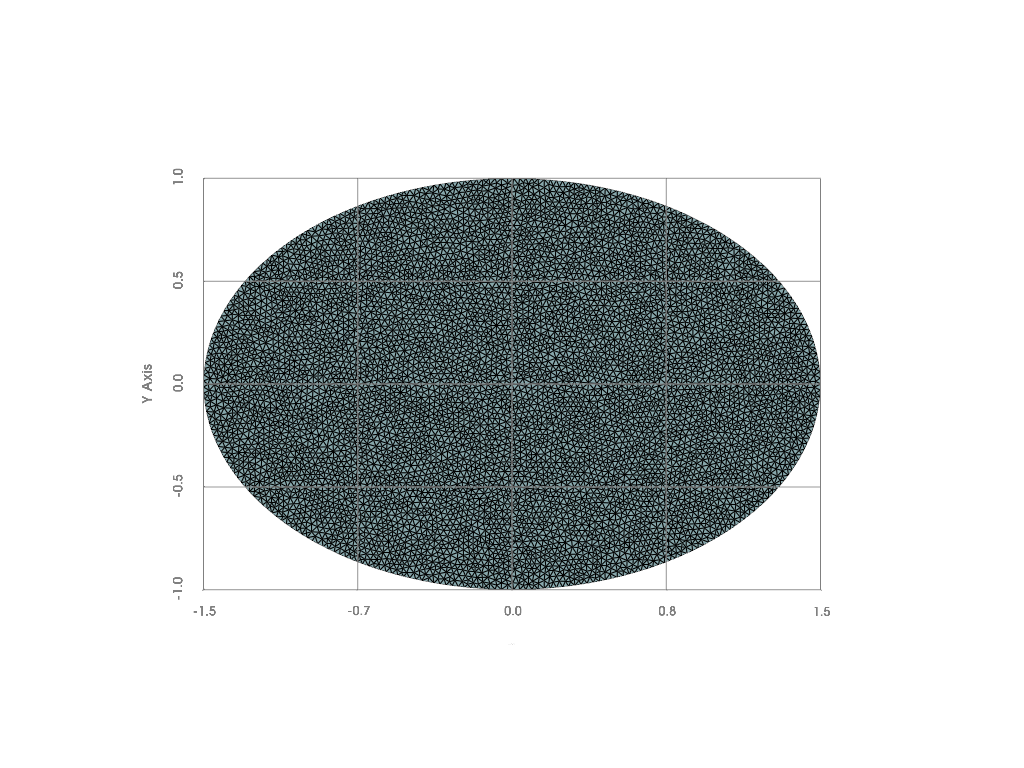

In [3]:
comm = MPI.COMM_WORLD
gmsh.initialize()
model = gmsh.model()
model.add("Ellipse")
model.setCurrent("Ellipse")

# Semiaxes of the ellipse
ellipse = model.occ.addDisk(0, 0, 0, geometrical_parameters["a"], geometrical_parameters["b"], tag=1)
model.occ.synchronize()
marker=1
model.addPhysicalGroup(2, [ellipse], 1)
model.setPhysicalName(2, marker, "Disk")

gmsh.option.setNumber("General.Verbosity", geometrical_parameters["verbosity"])
gmsh.option.setNumber("Mesh.Algorithm", geometrical_parameters["algorithm"])
gmsh.option.setNumber("Mesh.MeshSizeMin", geometrical_parameters["mesh_size"])
gmsh.option.setNumber("Mesh.MeshSizeMax", geometrical_parameters["mesh_size"])
model.mesh.setOrder(geometrical_parameters["mesh_order"])  # mesh order
model.mesh.generate(geometrical_parameters["gdim"])
msh, cell_tags, facet_tags = gmshio.model_to_mesh(model, comm, 0, gdim=2)
gmsh.finalize()


topology, cell_types, x = dolfinx.plot.vtk_mesh(msh)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show_bounds(
    color="gray",
    grid="front",
    location="outer",
    font_size=10,
    font_family="arial")
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(result_folder / "mesh.png")
        

# Function spaces and integration measures

We define a three-dimensional displacement field on a two-dimensional mesh, representing the cross-section. 
Hence, we introduce the definition of the projection of the displacement field on longitudinal and transverse directions.

The integration measures serve to integrate on the cross-section (`dx`) and its boundary (`ds`) is defined on the cross-section.

In [4]:

V_3d = fem.functionspace(
    msh, ("Lagrange", geometrical_parameters["mesh_order"], (3,))
)
u_3d = fem.Function(V_3d, name="u_3d")

dx = ufl.Measure("dx", domain=msh, metadata={"quadrature_degree": 4})
ds = ufl.Measure("ds", domain=msh)


u_transv = ufl.as_vector([u_3d[0], u_3d[1]])
u_long = u_3d[2]


# Variational formulation
Geometric deformations

In [5]:

def eps(u):
    """Geometrical deformation as a function of the micro-displacement

    Args:
        u (Function): The 3d displacement field

    Returns:
        Expression: The strain tensor using the beam model kinematics (see the documentation)
    """
    u_transv = ufl.as_vector([u[0], u[1]])
    u_long = u[2]
    sym_grad_u_transv = ufl.sym(ufl.grad(u_transv))
    grad_u_long = ufl.grad(u_long)

    eps_u_transv = ufl.as_tensor(
        [
            [sym_grad_u_transv[0, 0], sym_grad_u_transv[0, 1], 0],
            [sym_grad_u_transv[1, 0], sym_grad_u_transv[1, 1], 0],
            [0, 0, 0],
        ]
    )
    eps_u_long = ufl.as_tensor(
        [
            [0, 0, grad_u_long[0] / 2],
            [0, 0, grad_u_long[1] / 2],
            [grad_u_long[0] / 2, grad_u_long[1] / 2, 0],
        ]
    )
    return eps_u_transv + eps_u_long


Loading parameters defined in ufl

In [6]:
e = fem.Constant(msh, loading_parameters["e"])
tau = fem.Constant(msh, loading_parameters["tau"])
k_x = fem.Constant(msh, loading_parameters["k_x"])
k_y = fem.Constant(msh, loading_parameters["k_y"])

Inelastic deformations accounting for the extension, bending, and twist

In [7]:
x = ufl.SpatialCoordinate(msh)
eps_0_33 = -(e + k_x * x[1] - k_y * x[0])
eps_0_13 = x[1] * tau / 2
eps_0_23 = -x[0] * tau / 2
eps_0_3d = ufl.as_tensor(
    [
        [0, 0, eps_0_13],
        [0, 0, eps_0_23],
        [eps_0_13, eps_0_23, eps_0_33],
    ]
)

Definition of the elastic energy density and stress tensor

In [8]:
E = fem.Constant(msh, material_parameters["E"])
nu = fem.Constant(msh, material_parameters["nu"])
lmbda = E * nu / (1.0 + nu) / (1.0 - 2.0 * nu)
mu = E / 2.0 / (1.0 + nu)


def W(eps):
    """Strain energy density"""
    return 0.5 * lmbda * ufl.tr(eps) ** 2 + mu * ufl.inner(eps, eps)


def stress(eps):
    """Stress tensor"""
    return lmbda * ufl.tr(eps) * ufl.Identity(3) + 2.0 * mu * eps

Elastic energy

In [9]:
elastic_energy = W(eps(u_3d) - eps_0_3d) * dx
potential_energy = elastic_energy

Variational problem, giving the linear form L  and the bilinear form a

In [10]:
residual = ufl.derivative(potential_energy, u_3d, ufl.TestFunction(V_3d))
residual_linear = ufl.replace(residual, {u_3d: ufl.TrialFunction(V_3d)})
a = fem.form(ufl.lhs(residual_linear))
L = fem.form(ufl.rhs(residual_linear))

# Linear problem to solve (use PETSc LU solver)

In [11]:
from petsc4py import PETSc

def build_nullspace(V: fem.FunctionSpace):
    """Build PETSc nullspace for 3D elasticity"""

    # Create vectors that will span the nullspace
    bs = V.dofmap.index_map_bs
    length0 = V.dofmap.index_map.size_local
    basis = [
        dolfinx.la.vector(V.dofmap.index_map, bs=bs) for i in range(4)
    ]
    b = [b.array for b in basis]

    # Get dof indices for each subspace (x, y and z dofs)
    dofs = [V.sub(i).dofmap.list.flatten() for i in range(3)]

    # Set the three translational rigid body modes
    for i in range(3):
        b[i][dofs[i]] = 1.0

    # Set the three rotational rigid body modes
    x = V.tabulate_dof_coordinates()
    dofs_block = V.dofmap.list.flatten()
    x0, x1 = x[dofs_block, 0], x[dofs_block, 1]
    b[3][dofs[0]] = -x1
    b[3][dofs[1]] = x0

    _basis = [x._cpp_object for x in basis]
    dolfinx.cpp.la.orthonormalize(_basis)
    assert dolfinx.cpp.la.is_orthonormal(_basis)

    basis_petsc = [
        PETSc.Vec().createWithArray(
            x[: bs * length0], bsize=3, comm=V.mesh.comm
        )  # type: ignore
        for x in b
    ]
    return PETSc.NullSpace().create(vectors=basis_petsc)  # type: ignore

In [12]:
problem = fem.petsc.LinearProblem(
    a, L, u=u_3d, bcs=[], petsc_options={"ksp_type": "cg",
    "pc_type": "bjacobi"}
) # Need an iterative solver to attach nullspace and eliminate rigid body modes
null_space = build_nullspace(V_3d)
problem.A.setNullSpace(null_space)

Fields and expressions for postprocessing

In [13]:
S = fem.functionspace(msh, ("CG", geometrical_parameters["mesh_order"], (3, 3)))
sigma_ufl = stress(eps(u_3d) - eps_0_3d)
sigma_expressions = fem.Expression(sigma_ufl, S.element.interpolation_points())
sigma = fem.Function(S, name="Stress")

CG_1 = fem.functionspace(msh, ("CG", geometrical_parameters["mesh_order"], (1,)))
sigma_von_mises = fem.Function(CG_1, name="Von Mises stress")
sigma_von_mises_ufl = ufl.sqrt(
    3.0 / 2.0 * ufl.inner(ufl.dev(sigma_ufl), ufl.dev(sigma_ufl))
)
sigma_vonMises_expressions = fem.Expression(
    sigma_von_mises_ufl, CG_1.element.interpolation_points()
)
sigma_von_mises.interpolate(sigma_vonMises_expressions)

# Solving the problem for different loadings

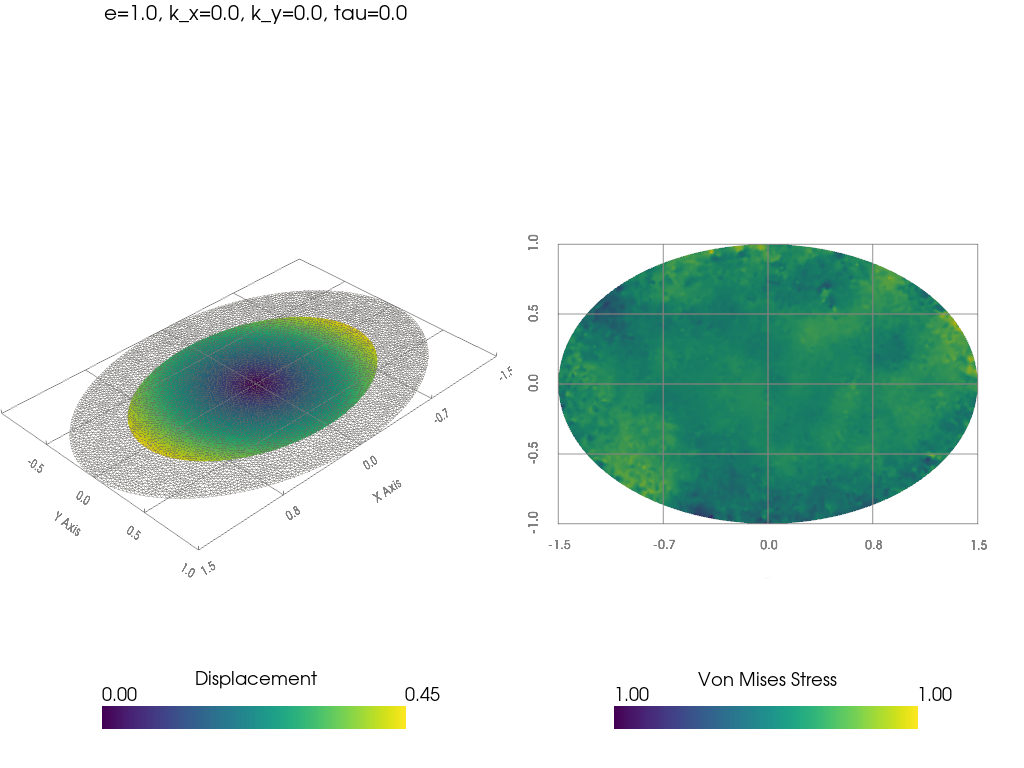

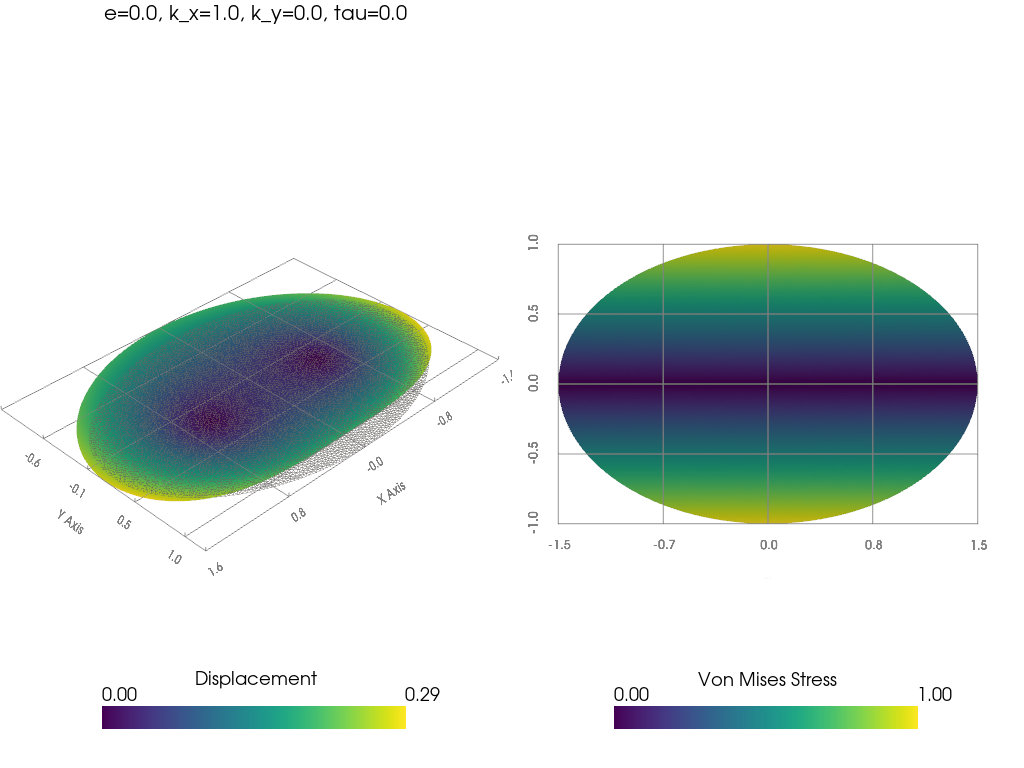

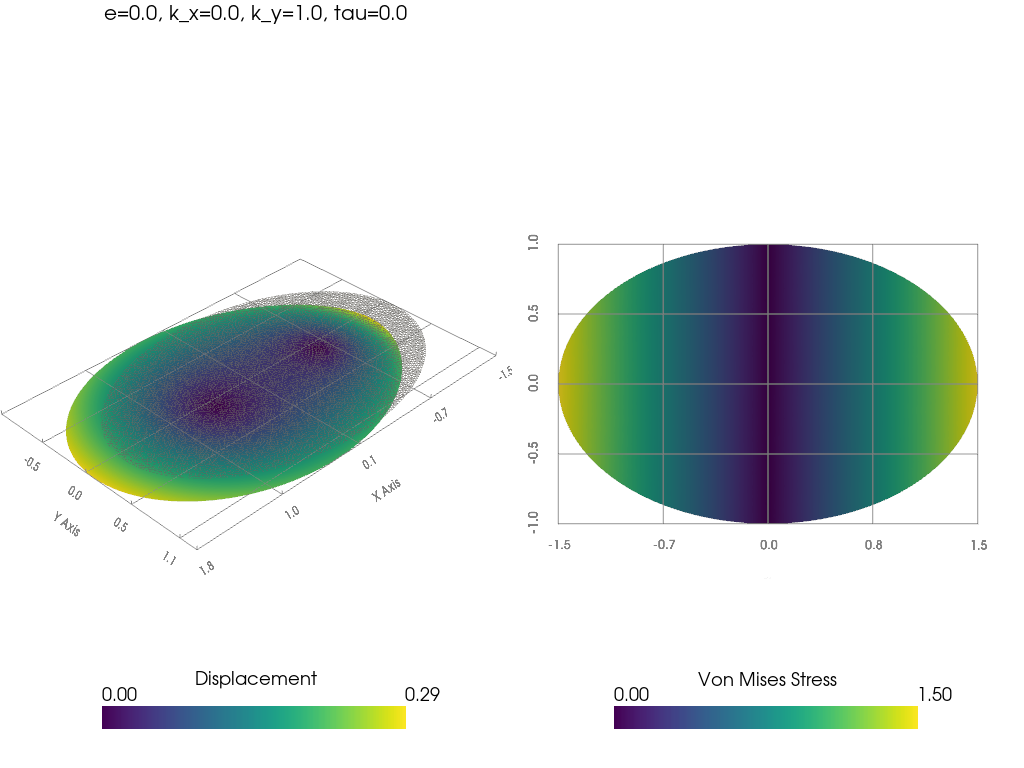

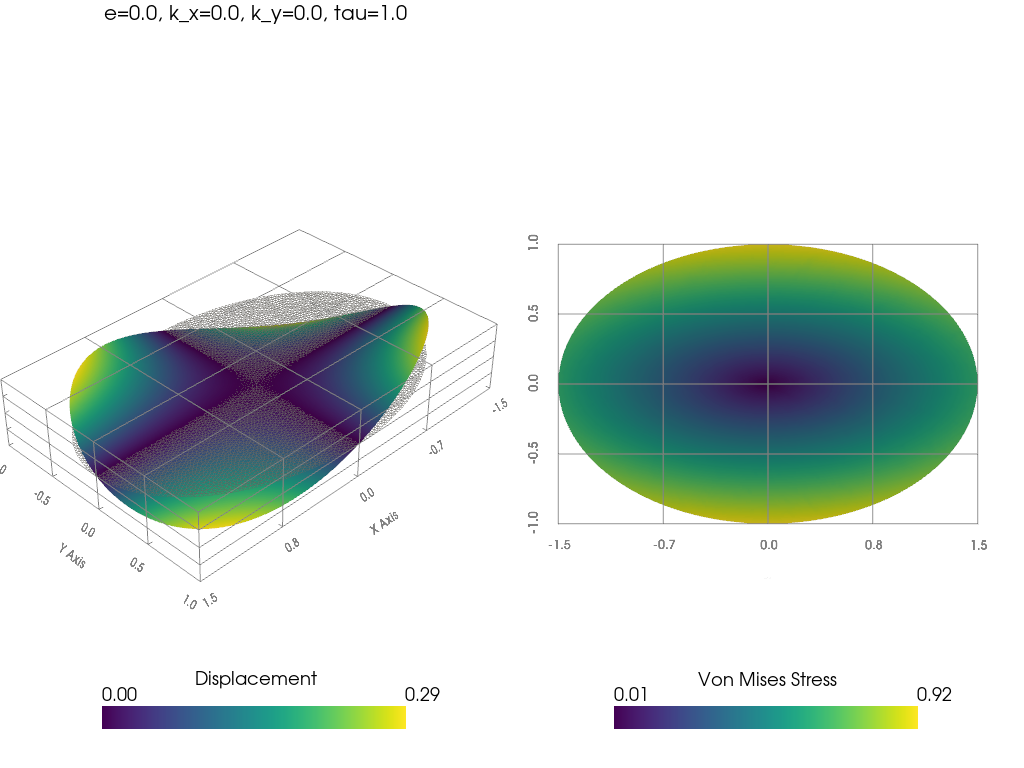

In [14]:
loading_cases = [
    {"e": 1.0, "k_x": 0.0, "k_y": 0.0, "tau": 0.0},
    {"e": 0.0, "k_x": 1.0, "k_y": 0.0, "tau": 0.0},
    {"e": 0.0, "k_x": 0.0, "k_y": 1.0, "tau": 0.0},
    {"e": 0.0, "k_x": 0.0, "k_y": 0.0, "tau": 1.0},
]

load_cases_labels = [
    "extension",
    "x-bending",
    "y-bending",
    "torsion"]

out_file = result_folder / Path("solution_all_loadings.xdmf")
with dolfinx.io.XDMFFile(msh.comm, out_file, "w") as xdmf:
    xdmf.write_mesh(msh)

energies = []

for i, loading_parameters in enumerate(loading_cases):
    e.value = loading_parameters["e"]
    k_x.value = loading_parameters["k_x"]
    k_y.value = loading_parameters["k_y"]
    tau.value = loading_parameters["tau"]
    problem.solve()
    energies.append(fem.assemble_scalar(fem.form(elastic_energy)))
    sigma.interpolate(sigma_expressions)
    xdmf.write_function(u_3d, float(i))
    xdmf.write_function(sigma, float(i))
    # Plot the VM stress
    sigma_von_mises.interpolate(sigma_vonMises_expressions)

    plotter = plot_displacement_stress(u_3d, sigma_von_mises)
    plotter.subplot(0, 0)
    plotter.add_text(
        rf"""e={e.value}, k_x={k_x.value}, k_y={k_y.value}, tau={tau.value}""",
        font_size=8,
        color="black",
        position="upper_edge",
    )
    if not pyvista.OFF_SCREEN:
        plotter.show()
    else:
        plotter.screenshot(result_folder / f"plot_{load_cases_labels[i]}.png")

# Verifing the results
This works for elliptical sections only

In [15]:
a = geometrical_parameters["a"]
b = geometrical_parameters["b"]
print(a, b)
A_ell = np.pi * a * b
B_1_ell = np.pi / 4 * a * b**3
B_2_ell = np.pi / 4 * a**3 * b
J_ell = np.pi * (a * b) ** 3 / (a**2 + b**2)
print(f"A_ell: Theory {A_ell**float(E):2.4f}, FE {(energies[0] * 2 ):2.4f}")
print(f"B_1_ell: Theory {B_1_ell*float(E):2.4f}, FE {(energies[1] * 2 ):2.4f}")
print(f"B_2_ell: Theory {B_2_ell/float(E):2.4f}, FE {(energies[2] * 2 ):2.4f}")
print(f"J_ell:  Theory {J_ell*float(mu):2.4f}, FE {(energies[3] * 2 ):2.2f}")

1.5 1.0
A_ell: Theory 4.7124, FE 4.7119
B_1_ell: Theory 1.1781, FE 1.1780
B_2_ell: Theory 2.6507, FE 2.6502
J_ell:  Theory 1.2548, FE 1.25
